# Installation of Packages

In [131]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from tensorflow.keras import activations
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist, cifar100

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [133]:


(x_train, y_train), (x_test, y_test) =  cifar100.load_data()



# Data Inspection / Visualization

In [134]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [135]:
numRows = x_train.shape[0]
numRows

50000

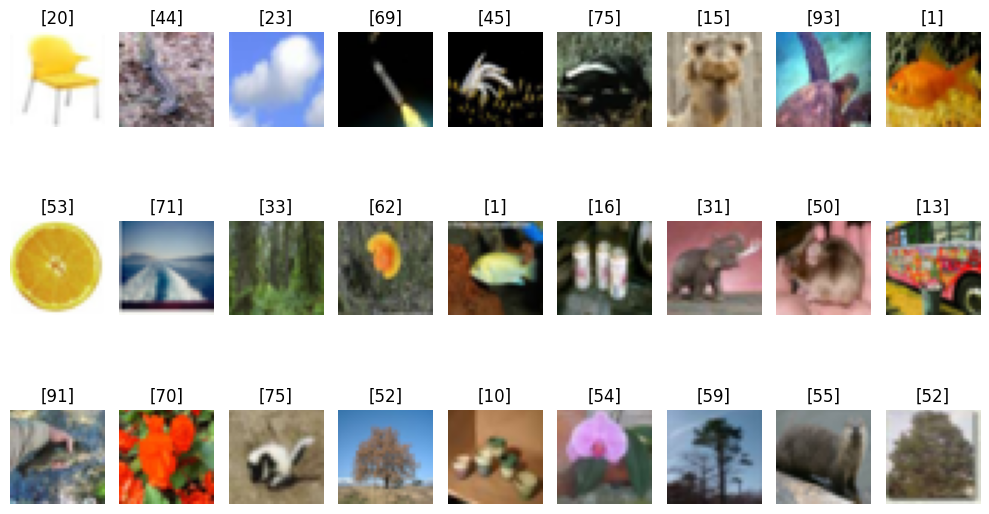

In [136]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
     plt.subplot(4, 9, i+1)
     item = x_train[int(randomIndex[i])]
     plt.imshow(item)
     plt.title(y_train[int(randomIndex[i])] )
     plt.axis(False)

plt.tight_layout()

# Data Preprocessing

In [137]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier


In [138]:
data_augmentation = models.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [139]:
num_classes = 100
input_shape = (32, 32, 3)

In [140]:
# num_classes = len(np.unique(y_train))
# input_shape = (32, 32, 1)


In [141]:
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

In [142]:
#print("x_train shape:", x_train.shape)
#print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")

In [143]:
#y_train = utils.to_categorical(y_train, num_classes)
#y_test = utils.to_categorical(y_test, num_classes)

# Data Postprocessing

# Model

In [144]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [145]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


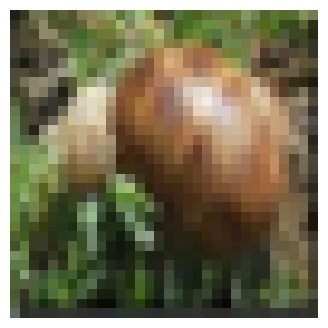

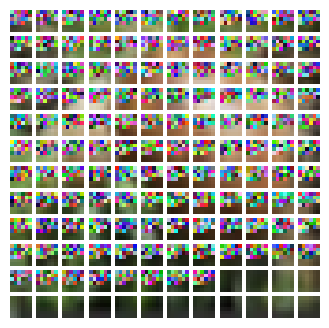

In [146]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [147]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [148]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = models.Model(inputs=inputs, outputs=logits)
    return model


In [149]:
model = create_vit_classifier()

In [150]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Compile

In [151]:

optimizer = optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
 
 

model.compile(
        optimizer=optimizer,
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            metrics.SparseCategoricalAccuracy(name="accuracy"),
            metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )


# Fit

In [152]:
checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [153]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )



Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 96s 388ms/step - accuracy: 0.0324 - loss: 4.8739 - top-5-accuracy: 0.1181 - val_accuracy: 0.1040 - val_loss: 3.8867 - val_top-5-accuracy: 0.3192
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.0838 - loss: 4.0210 - top-5-accuracy: 0.2666 - val_accuracy: 0.1588 - val_loss: 3.6102 - val_top-5-accuracy: 0.4030
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 404ms/step - accuracy: 0.1234 - loss: 3.7404 - top-5-accuracy: 0.3523 - val_accuracy: 0.1794 - val_loss: 3.4091 - val_top-5-accuracy: 0.4466
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 405ms/step - accuracy: 0.1547 - loss: 3.5511 - top-5-accuracy: 0.4071 - val_accuracy: 0.2306 - val_loss: 3.1874 - val_top-5-accuracy: 0.5126
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 405ms/step - accuracy: 0.1851 - loss: 3.3732 - top-5-accuracy: 0.4614 - val_accuracy: 0.2480 - val_loss: 3.0706 - val_top-5-accuracy: 0.5460
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 405ms/step - accuracy: 0.2075 -

# Evaluation

In [154]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
 

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3584 - loss: 2.5259 - top-5-accuracy: 0.6600
Test accuracy: 35.42%
Test top 5 accuracy: 65.7%


In [155]:
# score = model.evaluate(x_test, y_test, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

In [156]:
# def make_plot(metric):
#   plt.plot(history.history[metric ])
#   plt.plot(history.history['val_'+metric ])
#   plt.title( 'Model '+metric )
#   plt.ylabel( metric.capitalize() )
#   plt.xlabel( 'Epochs' )
#   plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
#   plt.show()

In [157]:
def make_plot(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item.capitalize())
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

 

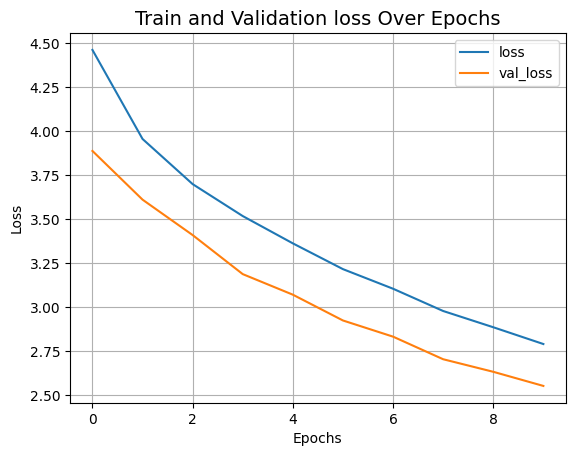

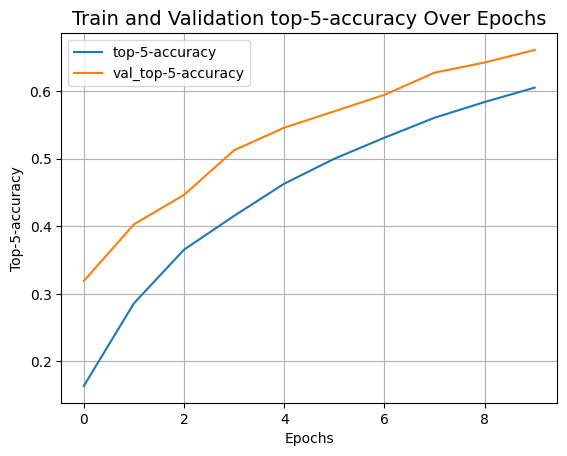

In [158]:
# make_plot('accuracy')
make_plot('loss')
make_plot("top-5-accuracy")

# Inference

# Deploy

In [159]:
#model.save("custom_image_classification_model")

In [160]:
#model.push_to_hub("Docty/OSCC-Xception")